In [1]:
import duckdb
import matplotlib.pyplot as plt
from matplotlib.scale import LogScale
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import copy

import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
from seaborn import plotting_context

In [2]:
my_style = {
    'figure.facecolor': 'white',
    'axes.labelcolor': '.15',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': '.15',
    'ytick.color': '.15',
    'axes.axisbelow': True,
    'grid.linestyle': '-',
    'text.color': '.0',
    'font.family': ['sans-serif'],
    'font.sans-serif': [
        'Arial',
        'DejaVu Sans',
        'Liberation Sans',
        'Bitstream Vera Sans',
        'sans-serif'
    ],
    'lines.solid_capstyle': 'round',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'image.cmap': 'rocket',
    'xtick.top': False,
    'ytick.right': False,
    'axes.grid': True,
    'axes.facecolor': 'white',
    'axes.edgecolor': '.0',
    'grid.color': '.9',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.bottom': False,
    'ytick.left': False
}

In [4]:
con = duckdb.connect('../benchmark/duckdb/eviction_policy.db', read_only=True)

In [71]:
df = con.execute("""
SELECT CASE policy
       WHEN 'all' THEN 'Mixed'
       WHEN 'temporary_persistent' THEN 'TemporaryFirst'
       WHEN 'persistent_temporary' THEN 'PersistentFirst'
       ELSE '' END AS "Eviction Policy",
       time AS "Execution Time [s]",
       CASE threads 
       WHEN 1 THEN '1 Connection'
       WHEN 4 THEN '4 Connections'
       ELSE '' END AS Connections,
       CASE tag
       WHEN 'BASE_TABLE' THEN 'Persistent'
       WHEN 'HASH_TABLE' THEN 'Temporary'
       ELSE '' END AS "Memory Usage",
       memory_usage_bytes / 1e9 AS "Memory [GB]",
FROM results
""").fetchdf()
df.head()

,Eviction Policy,Execution Time [s],Connections,Memory Usage,Memory [GB]
0,PersistentFirst,0.001851,4 Connections,Persistent,0.001964
1,PersistentFirst,0.001851,4 Connections,Temporary,0.004194
2,PersistentFirst,0.505835,4 Connections,Persistent,0.325188
3,PersistentFirst,0.505835,4 Connections,Temporary,0.729285
4,PersistentFirst,1.010063,4 Connections,Persistent,0.651295


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


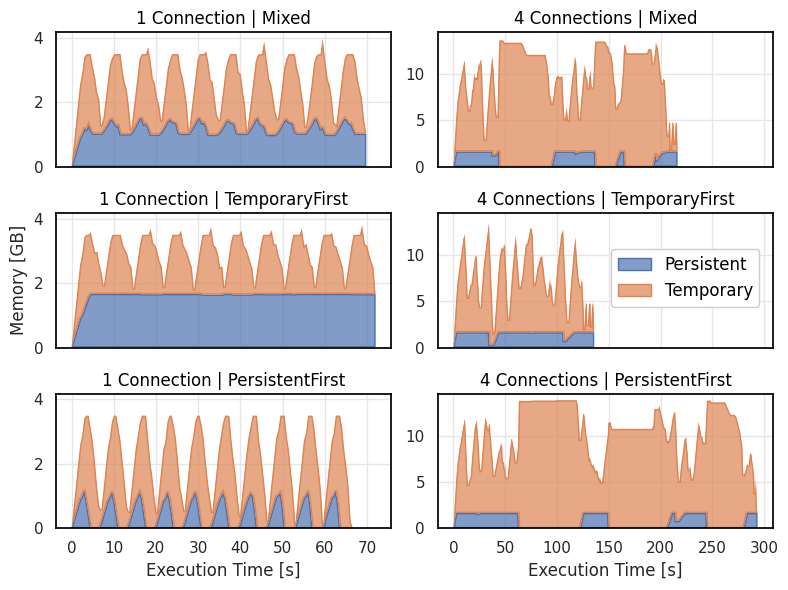

In [80]:
f = plt.figure(figsize=(8, 6))
p = (
    so.Plot(df, 'Execution Time [s]', 'Memory [GB]', color='Memory Usage')
    .add(so.Area(alpha=.7), so.Stack())
    .facet(row='Eviction Policy', col='Connections', order={'row': ['Mixed', 'TemporaryFirst', 'PersistentFirst'], 'col': ['1 Connection', '4 Connections']})
    .share(x='col', y='col')
    .theme(my_style)
    .on(f)
    .plot()
)

f.axes[0].set_ylabel('')
f.axes[4].set_ylabel('')

legend = f.legends.pop(0)
f.legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc=(0.775, 0.48), framealpha=1, ncol=1, fontsize=12)
# f.subplots_adjust(bottom=0.15)

f.tight_layout() #rect=[0, 0.03, 1, 0.95]
f.savefig("../figures/eviction_policy.eps", bbox_inches='tight')

# p

##### con = duckdb.connect('../benchmark/duckdb/eviction_policy.db', read_only=True)
df = con.execute("""
SELECT CASE policy
       WHEN 'all' THEN 'Mixed'
       WHEN 'temporary_persistent' THEN 'Temporary -> Persistent'
       WHEN 'persistent_temporary' THEN 'Persistent -> Temporary'
       ELSE '' END AS "Eviction Policy",
       time AS "Time [s]",
       threads as Connections,
       CASE tag
       WHEN 'BASE_TABLE' THEN 'Persistent Data'
       WHEN 'HASH_TABLE' THEN 'Temporary Data'
       ELSE '' END AS "Memory Usage",
       memory_usage_bytes / 1e9 AS "Memory [GB]",
FROM results
""").fetchdf()
df.head()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


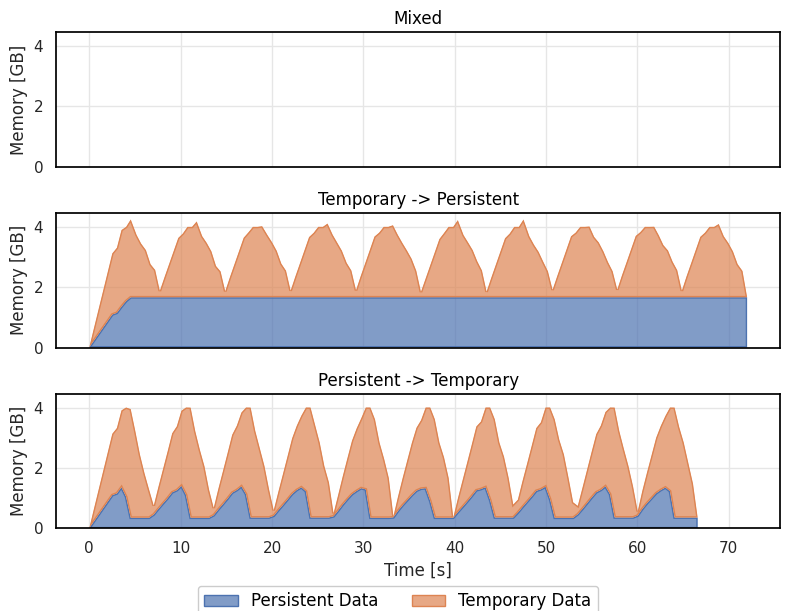

In [4]:
f = plt.figure(figsize=(8, 6))
p = (
    so.Plot(df, 'Time [s]', 'Memory [GB]', color='Memory Usage')
    .add(so.Area(alpha=.7), so.Stack())
    .facet(row='Eviction Policy', order=['Mixed', 'Temporary -> Persistent', 'Persistent -> Temporary'])
    .share(x='col', y='col')
    .theme(my_style)
    .on(f)
    .plot()
)

# f.axes[0].set_ylabel('')
# f.axes[2].set_ylabel('')

legend = f.legends.pop(0)
f.legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc=(0.25, -0.01), framealpha=1, ncol=2, fontsize=12)
f.subplots_adjust(bottom=0.3)

f.tight_layout()
f.savefig("../figures/eviction_policy_1.eps", bbox_inches='tight')

# p

In [67]:
con.execute("""
SELECT threads, policy, max(time)
FROM results
group by ALL
""").fetchdf()

,threads,policy,"max(""time"")"
0,4,temporary_persistent,135.940922
1,1,all,69.847654
2,4,persistent_temporary,293.536571
3,1,persistent_temporary,66.675905
4,4,all,216.393403
5,1,temporary_persistent,72.058387
